# Homework 2 - EECS 600 Deep Learning

Name: 

Instructions: All assignments are to be completed individually. Please complete each question as best you can. Once you have completed all of the problems, reset your runtime or kernel and run the notebook in order. Download the .ipynb file and submit it via Canvas.

Library usage: Several of the algorithms implemented in this, and other assignments, have implementations available in tensorflow. For this assignment, you are limited to basic operations within tensorflow and cannot use their high level APIs like tf.optimizer, tf.keras, etc.

All code presented in class is free to use in your assignments.

Your grade is based on the correctness of your implementation, not the quality of your code but you are encouraged to include comments in your code to help the graders understand your decisions.

For clarity, the final operation you should take is restarting the runtime and running all.

Due Date: 10/15/19 - midnight EST

100 Points Total

In [37]:
# For colab to upgrade matplotlib to 3.1.1
!pip install --upgrade matplotlib==3.1.1

Requirement already up-to-date: matplotlib==3.1.1 in /usr/local/lib/python3.6/dist-packages (3.1.1)


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import pandas as pd
import seaborn as sns
from numba import njit
%matplotlib inline
tf.enable_eager_execution()

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (x_train.shape[0], 28*28))
x_test = np.reshape(x_test, (x_test.shape[0], 28*28))
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255. 

## Recommendation
When building and testing your code, work on a smaller subset of the data. [This example](https://stackoverflow.com/questions/14262654/numpy-get-random-set-of-rows-from-2d-array) may help in that.

Additionally, if you are having trouble getting autoencoders to fit with sigmoid hidden units, feel free to change them to ReLU units instead.

# Question 1
Implement an autoencoder that encodes MNIST images as a 64 dimensional representation. Your hidden layer should use sigmoid activation functions. Determine an appropriate learning rate and number of epochs to train your model. Use a minibatch size of 128.

In [0]:
class FcLayer:

    def __init__(self, num_input, num_output, activation_func):
        self.b = tf.Variable(
            tf.constant(0.1, shape=num_output)
        )
        self.W = tf.Variable(
            tf.truncated_normal(
                shape=(num_input, num_output),
                stddev=0.2
            )
        )
        self.activation_func = activation_func
        self.all_variables = [self.W, self.b]
    
    def __call__(self, x):
        return self.forward(x)
    
    def forward(self, x):
        return self.activation_func(tf.matmul(x, self.W) + self.b)

# class OneHiddenLayerFcAutoencoder:
    
#     def __init__(self, num_input : int, num_hidden : int):
#         self.hidden_layer = FcLayer(num_input, num_hidden, tf.nn.sigmoid)
#         self.output_layer = FcLayer(num_hidden, num_input, tf.nn.sigmoid)
#         self.all_layers = [self.hidden_layer, self.output_layer]
        
#         self.all_variables = []
#         self.all_weights = []
#         for layer in reversed(self.all_layers):
#             self.all_variables.extend(layer.all_variables)
#             self.all_weights.append(layer.W)
        
#     def encode(self, x):
#         return self.hidden_layer.forward(x)
    
#     def decode(self, c):
#         return self.output_layer.forward(c)
    
#     def forward(self, x):
#         code = self.encode(x)
#         return self.decode(code)
    
#     def __call__(self, x):
#         return self.forward(x)
    
#     def backprop(self, inputs, stepper_func, loss_func, learning_rate):
#         with tf.GradientTape() as t:
#             current_loss = loss_func(self(inputs), inputs)
#             d_all_variables = t.gradient(current_loss, self.all_variables)
        
#         stepper_func(self.all_variables, d_all_variables, lr=learning_rate)

class OneHiddenLayerFcModel:
    
    def __init__(self, num_input : int, num_hidden : int, num_output : int,
                 hidden_activation=tf.nn.sigmoid, output_activation=tf.nn.sigmoid):
        self.hidden_layer = FcLayer(num_input, num_hidden, hidden_activation)
        self.output_layer = FcLayer(num_hidden, num_output, output_activation)
        self.all_layers = [self.hidden_layer, self.output_layer]
        
        self.all_variables = []
        self.all_weights = []
        for layer in reversed(self.all_layers):
            self.all_variables.extend(layer.all_variables)
            self.all_weights.append(layer.W)
        
    def encode(self, x):
        return self.hidden_layer.forward(x)
    
    def decode(self, c):
        return self.output_layer.forward(c)
    
    def forward(self, x):
        code = self.encode(x)
        return self.decode(code)
    
    def __call__(self, x):
        return self.forward(x)
    
    def backprop(self, inputs, outputs, stepper_func, loss_func, learning_rate):
        with tf.GradientTape() as t:
            current_loss = loss_func(self(inputs), outputs)
            d_all_variables = t.gradient(current_loss, self.all_variables)
        
        stepper_func(self.all_variables, d_all_variables, lr=learning_rate)
        
class OneHiddenLayerFcAutoencoder(OneHiddenLayerFcModel):
    
    def __init__(self, num_input : int, num_hidden : int,
                 hidden_activation=tf.nn.sigmoid, output_activation=tf.nn.sigmoid):
        super().__init__(num_input, num_hidden, num_input, hidden_activation, output_activation)
    
    def backprop(self, inputs, *arg, **kwargs):
        super().backprop(inputs, inputs, *arg, **kwargs)
        
def SGDStep(variables, gradients, lr):
    # performs SGD Step for given variables and gradient
    for V, dV in zip(variables, gradients):
        V.assign_sub(lr * dV)
        
def MeanSquareLoss(y, y_out):
    # Computes the mean-squared error of the true value y and output y from model
    return tf.reduce_mean(tf.squared_difference(y, y_out))

def train_autoencoder(model, stepper_func, loss_func,
                      x_train, y_train, x_test, y_test,
                      num_epochs, batch_size, learning_rate,
                      verbose=True, post_batch_action=lambda *args, **kwargs:None):
    __training_loss = []
    __testing_loss = []

    training_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))

    num_batches = len(x_train) // batch_size + 1

    __epoch_progress_bar = tqdm_notebook(
        range(1, num_epochs + 1),
        desc="Training", 
        disable=not verbose
    )

    for epoch_idx in __epoch_progress_bar:
        __training_dataset = training_dataset.shuffle(10000).batch(batch_size)

        __batch_progress_bar = tqdm_notebook(__training_dataset,
                                             total=num_batches,
                                             desc="Epoch %d" % epoch_idx,
                                             disable=not verbose,
                                             )

        for X, _ in __batch_progress_bar:
            model.backprop(X, stepper_func, loss_func, learning_rate)

        __epoch_train_loss = loss_func(model(x_train), x_train)
        __epoch_test_loss = loss_func(model(x_test), x_test)

        __training_loss.append(__epoch_train_loss)
        __testing_loss.append(__epoch_test_loss)

        if verbose:
            __epoch_progress_bar.write("Training Loss: %5f" % __epoch_train_loss)
            __epoch_progress_bar.write("Testing Loss: %5f" % __epoch_test_loss)
        
        post_batch_action()

    return __training_loss, __testing_loss

def plot_loss_by_epoch(trloss, tstloss, title=None, dpi=90, figsize=(5,5)):
    __figure = plt.figure(dpi=dpi, figsize=figsize)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    __num_epochs = len(trloss)
    plt.xlim([-1, __num_epochs])
    plt.xticks(range(-1, __num_epochs+1))
    __train_line, *_ = plt.plot(trloss, "-o")
    __test_line,*_ = plt.plot(tstloss, "-o")

    plt.legend([__train_line, __test_line], ["train", "test"])

def plot_random_reconstruct(model, test_x, test_y, size, dpi=70, figsize=(10, 10)):
    fig, axs = plt.subplots(*size, dpi=90, figsize=(20, 20))
    img_idxs = np.random.randint(0, len(test_x), size=size).flatten()
    imgs = np.reshape(model(test_x[img_idxs]), (-1, 28, 28))
    labels = test_y[img_idxs]

    for picax, idx, img, label in zip(axs.flat, img_idxs, imgs, labels):
        picax.set_title("Image %d Label %d" % (idx, label))
        picax.imshow(img, cmap=plt.cm.gray)
        picax.set_frame_on(False)
        picax.set_axis_off()
    
    plt.tight_layout()

In [41]:
q1p1_model = OneHiddenLayerFcAutoencoder(784, 64)

learning_rate = 90
num_epoch = 25
batch_size = 128

q1p1_losses = train_autoencoder(q1p1_model, SGDStep, MeanSquareLoss,
                              x_train, y_train, x_test, y_test,
                              num_epochs=num_epoch,
                              batch_size=batch_size,
                              learning_rate=learning_rate)

Training Loss: 0.033677
Testing Loss: 0.033410


Training Loss: 0.025163
Testing Loss: 0.024818


Training Loss: 0.020878
Testing Loss: 0.020505


Training Loss: 0.018369
Testing Loss: 0.018000


Training Loss: 0.016718
Testing Loss: 0.016371


Training Loss: 0.015498
Testing Loss: 0.015167


Training Loss: 0.014574
Testing Loss: 0.014253


Training Loss: 0.013777
Testing Loss: 0.013473


Training Loss: 0.013092
Testing Loss: 0.012796


Training Loss: 0.012932
Testing Loss: 0.012664


Training Loss: 0.011970
Testing Loss: 0.011703


Training Loss: 0.011632
Testing Loss: 0.011374


Training Loss: 0.011248
Testing Loss: 0.010995


Training Loss: 0.010969
Testing Loss: 0.010737


Training Loss: 0.010692
Testing Loss: 0.010458


Training Loss: 0.010661
Testing Loss: 0.010444


Training Loss: 0.009839
Testing Loss: 0.009620


Training Loss: 0.009899
Testing Loss: 0.009697


Training Loss: 0.009409
Testing Loss: 0.009210


Training Loss: 0.009193
Testing Loss: 0.008998


Training Loss: 0.009570
Testing Loss: 0.009375


Training Loss: 0.009131
Testing Loss: 0.008932


Training Loss: 0.009055
Testing Loss: 0.008867


Training Loss: 0.008903
Testing Loss: 0.008743


Training Loss: 0.008933
Testing Loss: 0.008788


Plot the training and testing reconstruction error for each epoch for your chosed number of epochs and learning rate using matplotlib.

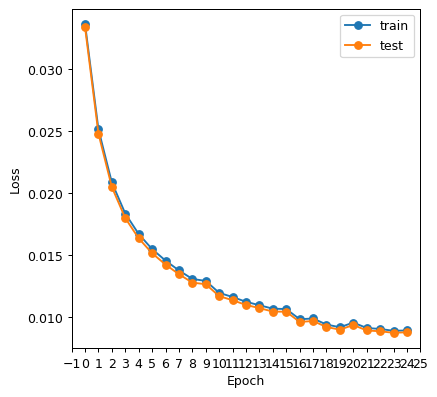

In [42]:
plot_loss_by_epoch(*q1p1_losses)

Plot a 10x10 image of reconstructred random examples from your testing set.

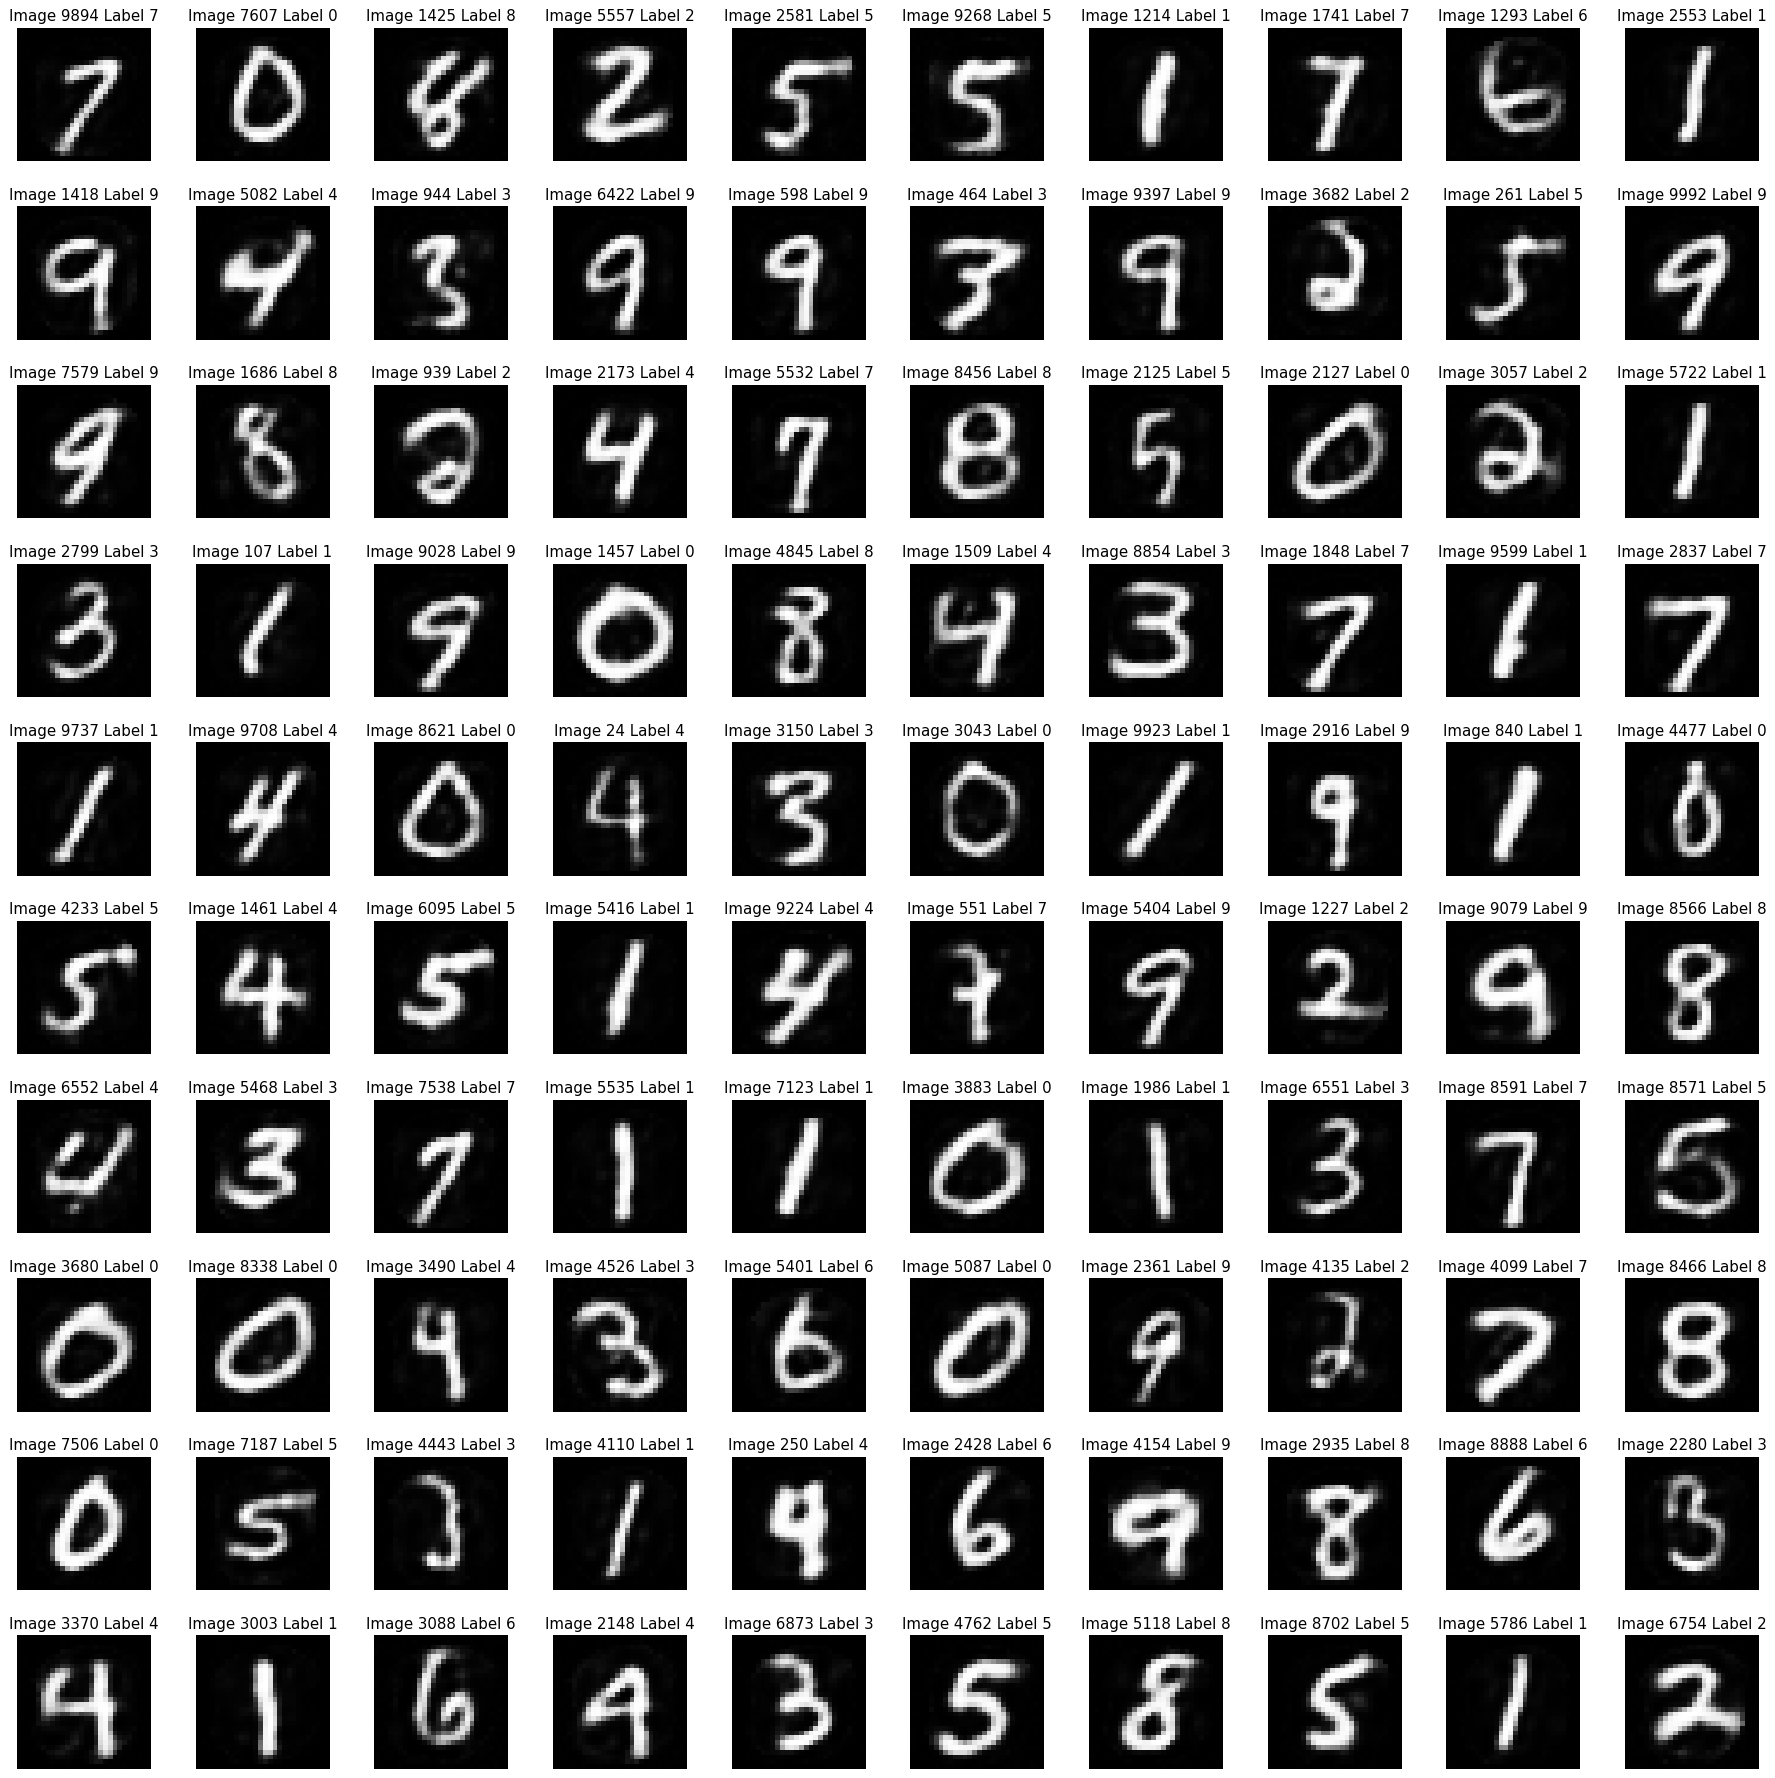

In [43]:
plot_random_reconstruct(q1p1_model, x_test, y_test, (10,10), figsize=(8,8))

How did you determine the appropriate learning rate and number of epochs for training?

We followed a trial-and-update approach to find the optimal learning rate and number of epochs and found that one optimal combination is $\text{Learning Rate} : 115, \text{Num Epoch}: 20$.

We also conducted a randomized search in the linear space of learning rate and number of epochs to find the value that minimizes the loss. However, <u>this process is unpleasantly slow, therefore, not suggested</u>. We also conducted research on multiple "auto-tuning" software package for deep learning modules. They are `ray | tune`, `HParam` from `tensorflow`, and `nni` from Microsoft. Most of the existing tools combines intelligent pruning and parallel architecture to speed up the process. 

## Question 1 Part 2
Add an $L_1$ regularization weight term to your loss function only on the weights to your encoder. Your new loss function should be $L(X) = \sum_i(X_i - decode(encode(X_i)))^2 + \alpha\sum_j|W_j|$ where $X$ is a minibatch of your data. Determine an appropriate value of $\alpha$. If you are having trouble getting started, consider values in powers of 10, i.e. $\alpha = 10^-5, 10^-4, 10^-3, ..., 10^1, 10^2, 10^3$.

In [0]:
# Q1P2 Regularized SD
class L2RegularizedSquareDiffLoss:
    
    def __init__(self, beta, model):
        self.beta = beta
        self.Ws = model.all_weights
    
    def l2reg(self):
        return tf.add_n([tf.nn.l2_loss(W) for W in self.Ws])

    def __call__(self, y, y_out):
        mseloss = tf.reduce_mean(tf.squared_difference(y, y_out))
        l2reg = self.l2reg()
        return tf.reduce_mean(mseloss + self.beta * l2reg)

In [45]:
q1p2_model = OneHiddenLayerFcAutoencoder(784, 64)

learning_rate = 55
num_epoch = 25
batch_size = 128

q1p2_regularized_squared_error_loss_func = L2RegularizedSquareDiffLoss(10**-5, q1p2_model)
q1p2_l2regs = []

q1p2_losses = train_autoencoder(q1p2_model, SGDStep, q1p2_regularized_squared_error_loss_func,
                                x_train, y_train, x_test, y_test,
                                num_epochs=num_epoch,
                                batch_size=batch_size,
                                learning_rate=learning_rate,
                                post_batch_action=lambda *args, **kwargs: 
                                        q1p2_l2regs.append(q1p2_regularized_squared_error_loss_func.l2reg())
                                )

Training Loss: 0.054205
Testing Loss: 0.053965


Training Loss: 0.045363
Testing Loss: 0.045073


Training Loss: 0.041138
Testing Loss: 0.040832


Training Loss: 0.038800
Testing Loss: 0.038485


Training Loss: 0.037398
Testing Loss: 0.037066


Training Loss: 0.036558
Testing Loss: 0.036218


Training Loss: 0.036041
Testing Loss: 0.035700


Training Loss: 0.035675
Testing Loss: 0.035336


Training Loss: 0.035408
Testing Loss: 0.035060


Training Loss: 0.035203
Testing Loss: 0.034866


Training Loss: 0.035051
Testing Loss: 0.034713


Training Loss: 0.034930
Testing Loss: 0.034593


Training Loss: 0.034838
Testing Loss: 0.034507


Training Loss: 0.034756
Testing Loss: 0.034427


Training Loss: 0.034686
Testing Loss: 0.034356


Training Loss: 0.034630
Testing Loss: 0.034305


Training Loss: 0.034576
Testing Loss: 0.034251


Training Loss: 0.034528
Testing Loss: 0.034201


Training Loss: 0.034482
Testing Loss: 0.034160


Training Loss: 0.034439
Testing Loss: 0.034117


Training Loss: 0.034404
Testing Loss: 0.034080


Training Loss: 0.034365
Testing Loss: 0.034042


Training Loss: 0.034331
Testing Loss: 0.034011


Training Loss: 0.034296
Testing Loss: 0.033972


Training Loss: 0.034266
Testing Loss: 0.033948


Plot the training and testing reconstruction error for each epoch for your chosed number of epochs and learning rate using matplotlib. Additionally, plot the weight regularization value at each epoch ($\sum_j|W_j|$).

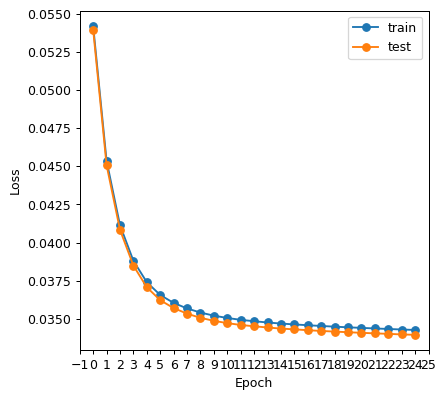

In [46]:
plot_loss_by_epoch(*q1p2_losses)

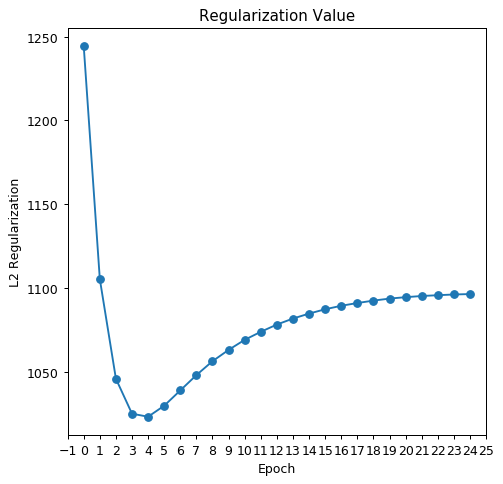

In [47]:
__figure = plt.figure(dpi=90, figsize=(6,6))
plt.title("Regularization Value")
plt.xlabel("Epoch")
plt.ylabel("L2 Regularization")

__num_epochs = len(q1p2_l2regs)
plt.xlim([-1, __num_epochs])
plt.xticks(range(-1, __num_epochs+1))
plt.plot(q1p2_l2regs, "-o")

How did you determine the appropriate weight regularization parameter?

## Question 2 Part 1

One of the [first papers](https://www.cs.toronto.edu/~hinton/science.pdf) in the deep learning literature proposed greedy layer wise training of deep neural networks. A greedy deep autoencoder first trains the first autoencoder, uses the representation to train the second autoencoder, etc. Train a greedy deep network for the MNIST data with the following layer sizes 400 - 200 - 50 - 10 - 2. Train on a random sample of 20000 MNIST rows. Use sigmoid activation layers and determine an appropriate learning rate.

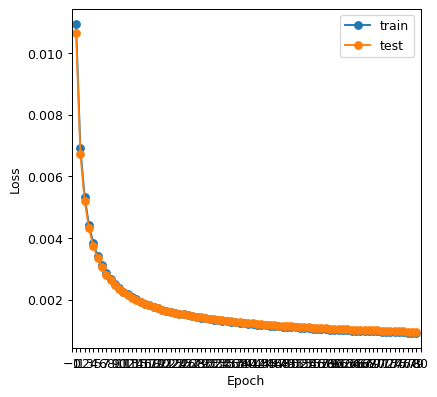

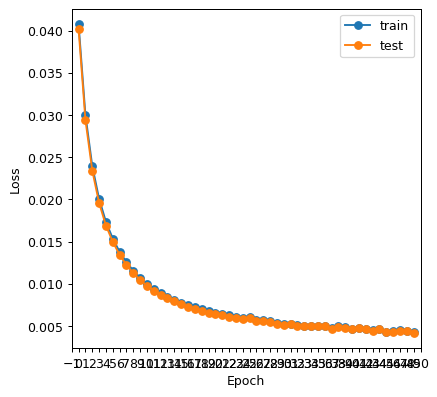

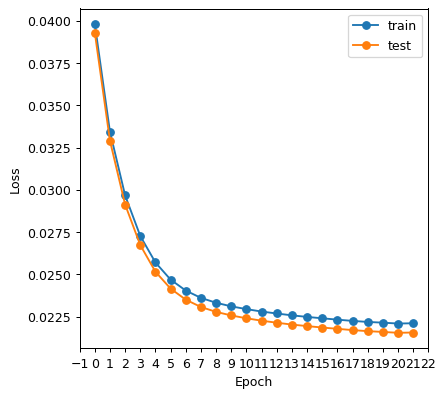

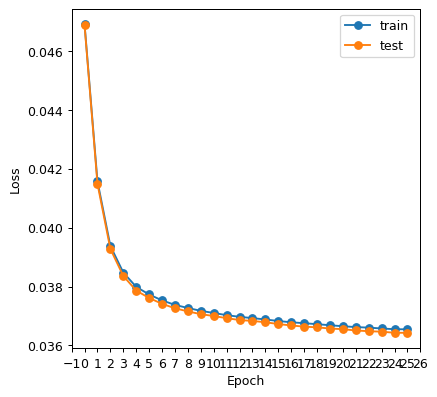

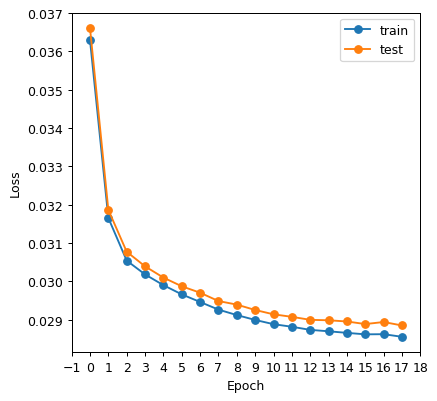

In [55]:
q2p1_all_code_sizes = [400, 200, 50, 10, 2]
q2p1_all_code_configs = [
    {
        "lr": 120,
        "num_epoch": 80,
    },
    {
        "lr": 28,
        "num_epoch": 50,
    },
    {
        "lr": 30,
        "num_epoch": 22,
    },
    {
        "lr": 18,
        "num_epoch": 26,
    },
    {
        "lr": 8,
        "num_epoch": 18,
    }
]

# Execution of greedy deep autoencoder
q2p1_all_models = []
q2p1_all_losses = []

batch_size = 128

last_code_size = 784

__x_train = x_train
__x_test = x_test

__all_x_trains = []
__all_x_tests = []

for code_size, config in tqdm_notebook(
    zip(q2p1_all_code_sizes, q2p1_all_code_configs),
    total=len(q2p1_all_code_sizes),
    desc="Greedy Autoencoder"
):
    __current_model = OneHiddenLayerFcAutoencoder(last_code_size, code_size)
    __current_losses = train_autoencoder(__current_model, SGDStep, MeanSquareLoss,
                                         __x_train, y_train, __x_test, y_test,   # wont use y
                                         num_epochs=config["num_epoch"],
                                         batch_size=batch_size,
                                         learning_rate=config["lr"],
                                         verbose=False)
    plot_loss_by_epoch(*__current_losses)
    q2p1_all_models.append(__current_model)
    q2p1_all_losses.append(__current_losses)
    __x_train = __current_model.encode(__x_train)
    __x_test = __current_model.encode(__x_test)
    __all_x_trains.append(__x_train)
    __all_x_tests.append(__x_test)

    last_code_size = code_size

Plot the two dimensional representation and the associated labels for the numbers for the testing data. See figure 3B in the above paper for an example.

In [56]:
# prepare data
__x_train = x_train
__x_test = x_test
for i in tqdm(range(len(q2p1_all_models) - 1)):
    __x_train = q2p1_all_models[i].encode(__x_train)
    __x_test  = q2p1_all_models[i].encode(__x_test)
    
# model for 2-label
label_models = q2p1_all_models[-1]
__q2p1_x_test = label_models.encode(__x_test)

100%|██████████| 4/4 [00:00<00:00, 60.35it/s]


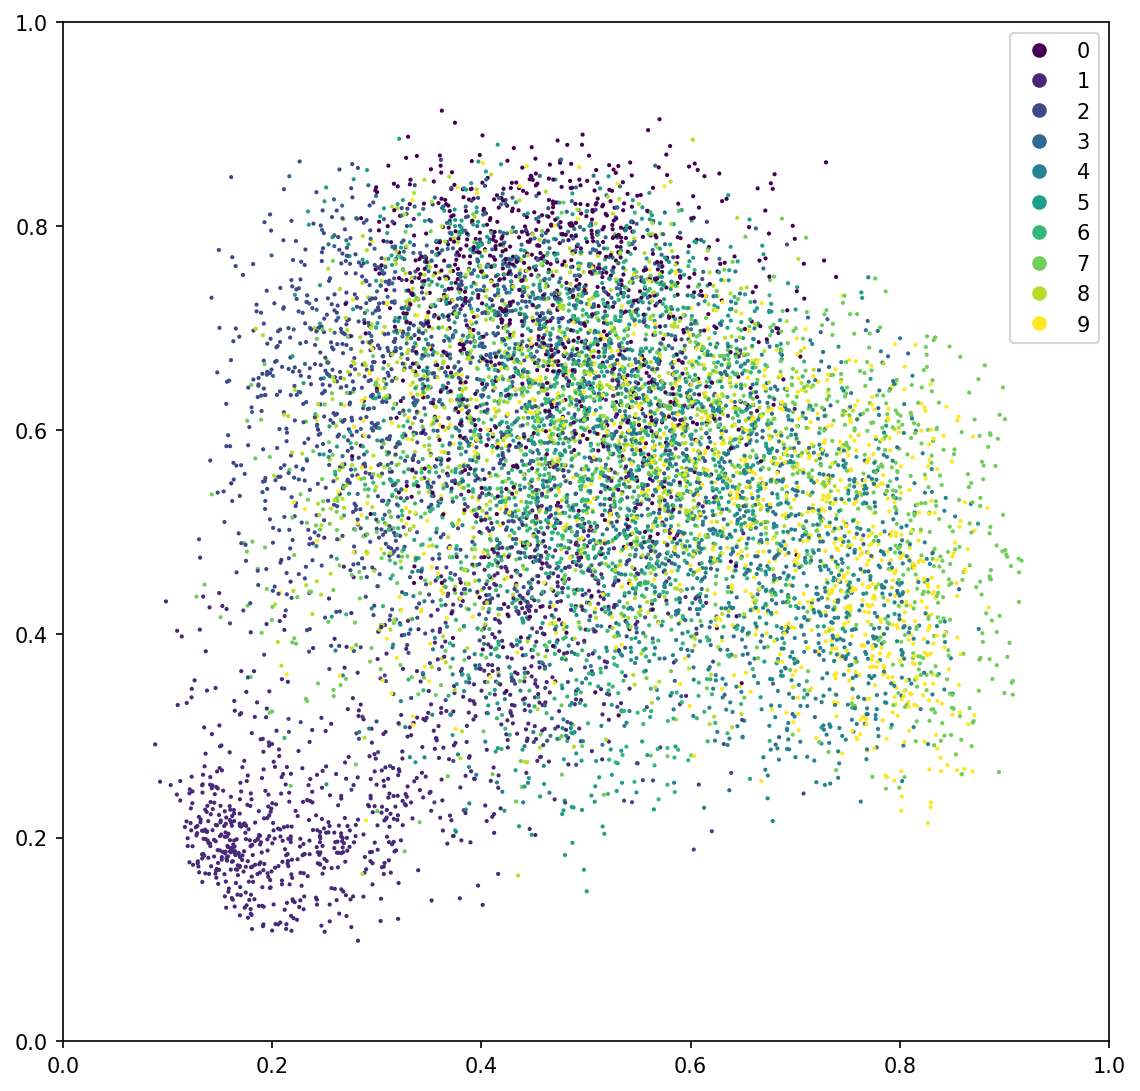

In [58]:
fig = plt.figure(dpi=150, figsize=(9,9))

scatter = plt.scatter(*tf.transpose(__q2p1_x_test), c=y_test, s=1)
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])

plt.legend(*scatter.legend_elements())

## Question 2 Part 2
Instead of training a multi-layer deep architecture, train just one layer of size 2. Once again use sigmoid activation functions and determine an appropriate learning rate.

Training Loss: 0.070553
Testing Loss: 0.070815


Training Loss: 0.068653
Testing Loss: 0.068902


Training Loss: 0.068114
Testing Loss: 0.068354


Training Loss: 0.067867
Testing Loss: 0.068104


Training Loss: 0.067728
Testing Loss: 0.067964


Training Loss: 0.067637
Testing Loss: 0.067872


Training Loss: 0.067577
Testing Loss: 0.067810


Training Loss: 0.067531
Testing Loss: 0.067764


Training Loss: 0.067496
Testing Loss: 0.067721


Training Loss: 0.067469
Testing Loss: 0.067701


Training Loss: 0.067447
Testing Loss: 0.067681


Training Loss: 0.067431
Testing Loss: 0.067659


Training Loss: 0.067414
Testing Loss: 0.067644


Training Loss: 0.067402
Testing Loss: 0.067626


Training Loss: 0.067391
Testing Loss: 0.067622


Training Loss: 0.067381
Testing Loss: 0.067607


Training Loss: 0.067372
Testing Loss: 0.067599


Training Loss: 0.067366
Testing Loss: 0.067587


Training Loss: 0.067360
Testing Loss: 0.067590


Training Loss: 0.067355
Testing Loss: 0.067581


Training Loss: 0.067349
Testing Loss: 0.067580


Training Loss: 0.067344
Testing Loss: 0.067570


Training Loss: 0.067339
Testing Loss: 0.067565


Training Loss: 0.067336
Testing Loss: 0.067562


Training Loss: 0.067332
Testing Loss: 0.067558


Training Loss: 0.067329
Testing Loss: 0.067554


Training Loss: 0.067329
Testing Loss: 0.067556


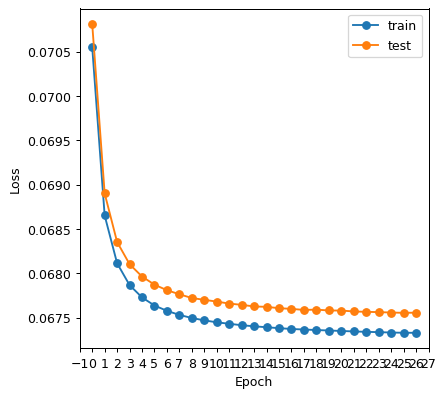

In [59]:
q2p2_model = OneHiddenLayerFcAutoencoder(784, 2)

learning_rate = 30
num_epoch = 27
batch_size = 128

q2p2_losses = train_autoencoder(q2p2_model, SGDStep, MeanSquareLoss,
                                x_train, y_train, x_test, y_test,
                                num_epochs=num_epoch,
                                batch_size=batch_size,
                                learning_rate=learning_rate)
plot_loss_by_epoch(*q2p2_losses)

Plot the two dimensional representation and the associated labels for the numbers for the testing data. See figure 3B in the above paper for an example.

In [60]:
__q2p2_x_test = q2p2_model.encode(x_test)

__q2p2_x_test.shape

TensorShape([Dimension(10000), Dimension(2)])

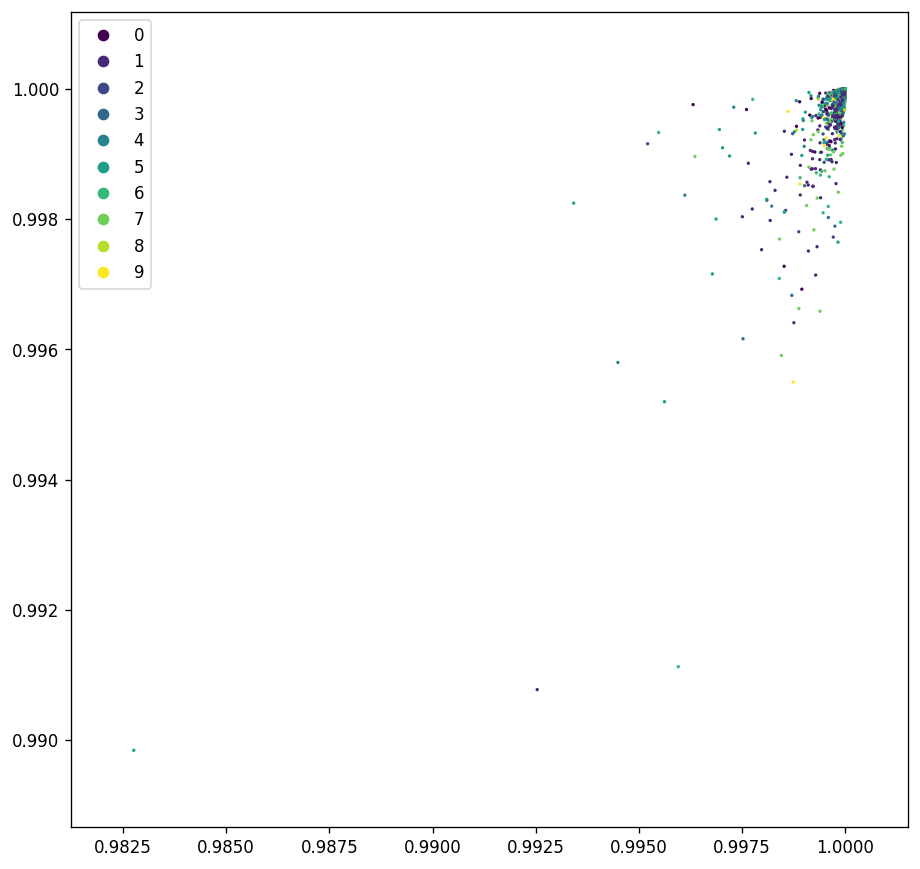

In [61]:
fig = plt.figure(dpi=120, figsize=(9,9))

scatter = plt.scatter(*tf.transpose(__q2p2_x_test), c=y_test, s=1)

plt.legend(*scatter.legend_elements())

## Question 2 Part 3
Train a standard feed-forward neural network with one hidden layer of size two and sigmoid activation functions for predicting which digit each of the training samples is from.

In [0]:
# Modified from Homework 1

def train_nn(model, stepper_func, loss_func, acc_func,
                      x_train, y_train, x_test, y_test,
                      num_epochs, batch_size, learning_rate,
                      verbose=True):
    __training_loss = []
    __testing_loss = []
    __training_accuracy = []
    __testing_accuracy = []

    training_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    num_batches = len(x_train) // batch_size + 1

    __epoch_progress_bar = tqdm_notebook(
        range(1, num_epochs + 1),
        desc="Training", 
        disable=not verbose
    )

    for epoch_idx in __epoch_progress_bar:

        # Train on the whole dataset
        __training_dataset = training_dataset.shuffle(10000).batch(batch_size)
        __batch_progress_bar = tqdm_notebook(__training_dataset,
                                             total=num_batches,
                                             desc="Epoch %d" % epoch_idx,
                                             disable=not verbose,
                                             )
        for X, y in __batch_progress_bar:
            model.backprop(X, y, stepper_func, loss_func, learning_rate)

        # Compute loss and accuracy
        __epoch_train_loss = loss_func(model(x_train), y_train)
        __epoch_test_loss = loss_func(model(x_test), y_test)

        __epoch_train_accuracy = acc_func(model(x_train), y_train)
        __epoch_test_accuracy = acc_func(model(x_test), y_test)

        __training_loss.append(__epoch_train_loss)
        __training_accuracy.append(__epoch_train_accuracy)

        __testing_loss.append(__epoch_test_loss)
        __testing_accuracy.append(__epoch_test_accuracy)

        if verbose:
            __epoch_progress_bar.write("Test loss: %5f" % __epoch_test_loss)
            __epoch_progress_bar.write(
                "Test accuracy: %f" % __epoch_test_accuracy)

    return __training_loss, __training_accuracy, __testing_loss, __testing_accuracy

def prob_accuracy(y_out_hat, y_out):
    """
    The validation accuracy given the predict value and ground truth

    Observed that the output of neural network is a vector of probability of each label,
    we take the `argmax` of the probability vector to convert to labels
    """
    y_hat = tf.math.argmax(y_out_hat, axis=1)
    y = tf.math.argmax(y_out, axis=1)

    eq = tf.math.equal(y_hat, y)
    nnz = tf.count_nonzero(eq)
    return nnz / y.shape[0]

def plot_loss_acc_by_epoch(trloss, tracc, tstloss, tstacc, dpi=80, figsize=[13, 5.3]):
    fig, axs = plt.subplots(1, 2, sharex=True, dpi=dpi, figsize=figsize)
    __num_epochs = len(trloss)

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_xlim([-1, __num_epochs])
    axs[0].set_xticks(range(-1, __num_epochs + 1))
    __train_line, *_ = axs[0].plot(trloss, "-o")
    __test_line, *_ = axs[0].plot(tstloss, "-o")

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_ylim([0, 1])
    axs[1].plot(tracc, "-o")
    axs[1].plot(tstacc, "-o")

    plt.legend([__train_line, __test_line], ["train", "test"])

In [63]:
q2p3_model = OneHiddenLayerFcModel(784, 2, 10, output_activation=tf.nn.softmax)

learning_rate = 30
num_epoch = 27
batch_size = 128

q2p3_losses = train_nn(q2p3_model, SGDStep, MeanSquareLoss, prob_accuracy,
                                x_train, tf.one_hot(y_train, 10), x_test, tf.one_hot(y_test, 10),
                                num_epochs=num_epoch,
                                batch_size=batch_size,
                                learning_rate=learning_rate)

Test loss: 0.063759
Test accuracy: 0.435800


Test loss: 0.063213
Test accuracy: 0.463600


Test loss: 0.064405
Test accuracy: 0.457500


Test loss: 0.060195
Test accuracy: 0.488300


Test loss: 0.059131
Test accuracy: 0.511900


Test loss: 0.058204
Test accuracy: 0.515800


Test loss: 0.061007
Test accuracy: 0.492900


Test loss: 0.059164
Test accuracy: 0.505500


Test loss: 0.058068
Test accuracy: 0.524600


Test loss: 0.057718
Test accuracy: 0.528100


Test loss: 0.066470
Test accuracy: 0.457100


Test loss: 0.068006
Test accuracy: 0.397000


Test loss: 0.058250
Test accuracy: 0.536300


Test loss: 0.058028
Test accuracy: 0.511000


Test loss: 0.068757
Test accuracy: 0.408500


Test loss: 0.057754
Test accuracy: 0.528500


Test loss: 0.062941
Test accuracy: 0.463800


Test loss: 0.060221
Test accuracy: 0.491000


Test loss: 0.058843
Test accuracy: 0.508100


Test loss: 0.060324
Test accuracy: 0.514300


Test loss: 0.059187
Test accuracy: 0.520400


Test loss: 0.058640
Test accuracy: 0.526100


Test loss: 0.061447
Test accuracy: 0.500100


Test loss: 0.060200
Test accuracy: 0.526100


Test loss: 0.056511
Test accuracy: 0.549600


Test loss: 0.063255
Test accuracy: 0.468400


Test loss: 0.058325
Test accuracy: 0.534300


Pot the loss function and accuracy of your model

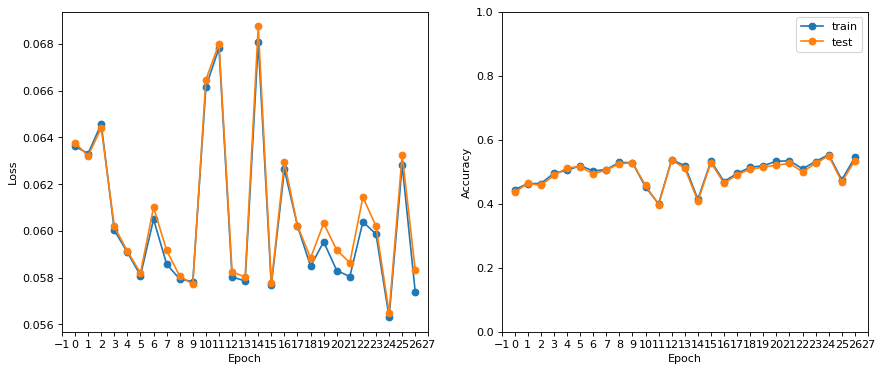

In [64]:
plot_loss_acc_by_epoch(*q2p3_losses)

Plot the two dimensional representation and the associated labels for the numbers for the testing data. See figure 3B in the above paper for an example.

In [65]:
__q2p3_x_test = q2p3_model.encode(x_test)

__q2p3_x_test.shape

TensorShape([Dimension(10000), Dimension(2)])

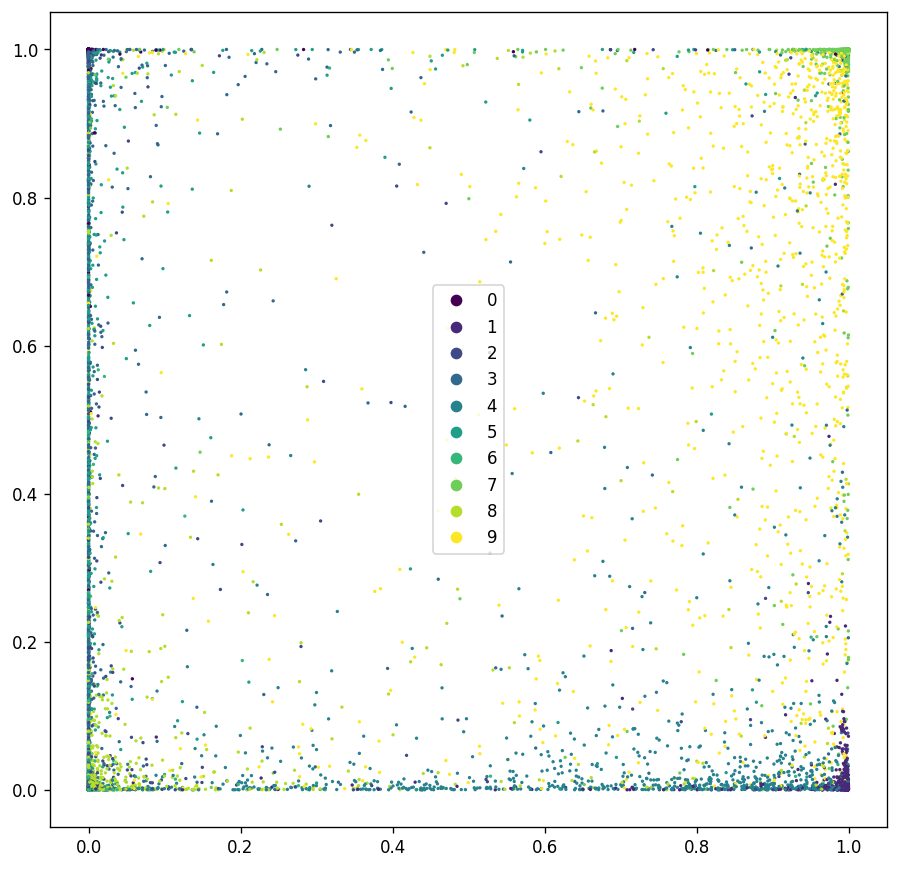

In [66]:
fig = plt.figure(dpi=120, figsize=(9,9))

scatter = plt.scatter(*tf.transpose(__q2p3_x_test), c=y_test, s=1)

plt.legend(*scatter.legend_elements())

## Question 2 Part 4
How different are the representations that the different approaches learned? What might make them different?

# Question 3 Part 1
Build a denoising autoencoder for the MNIST data. On each batch, add random [normal gaussian noise](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html) to the inputs and then [clip the values](https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html) such that they are between 0 and 1. Evaluate the following mean and standard deviation values for the noise.

| Mean  | Standard Deviation |
|-------|--------------------|
| (loc) | (scale)            |
| 0.0   | 0.05               |
| 0.1   | 0.05               |
| 0.0   | 0.2                |
| 0.1   | 0.2                |

Your evaluation should compare the reconstruction error on the testing data with no added error. Use sigmoid activation functions with 64 hidden units.

In [0]:
class OneHiddenLayerFcDenoiseAutoencoder(OneHiddenLayerFcModel):
    
    def __init__(self, num_input : int, num_hidden : int, noise_func, *args, 
                 train_on_original=False, **kwargs):
        super().__init__(num_input, num_hidden, num_input, *args, **kwargs)
        self.noise_func = noise_func
        self.train_on_original=train_on_original
    
    def backprop(self, inputs, *arg, **kwargs):
        super().backprop(self.noise_func(inputs), inputs, *arg, **kwargs)
        if self.train_on_original:
            super().backprop(inputs, inputs, *arg, **kwargs)

def gaussian_noise_func(loc, scale):
    def __wrapper(x):
        noise = tf.random.normal(x.shape, loc, scale)
        return x + noise
    return __wrapper

In [0]:
# __q3p1_gaussian_params = [(0.0, 0.05), (0.1, 0.05), (0.0, 0.2), (0.1, 0.2)]
# __q3p1_model_params = []
# for gp in __q3p1_gaussian_params:
#     for b in [True, False]:
#         __q3p1_model_params.append(gp + (b, ))
# __q3p1_hyperparams = [(40, 27), (40, 27), (40, 27), (40, 27),(45, 27), (45, 27), (45, 27), (45, 27)]

# # Model running
# batch_size=128
# __q3p1_models = []
# __q3p1_losses = []
# for (*gparam, train_on_original), (lr, epoch) in tqdm_notebook(
#                                 zip(__q3p1_model_params, __q3p1_hyperparams), 
#                                 total=len(__q3p1_model_params),
#                                 desc="Training Denoise Autoencoders"):
#     __noise_func = gaussian_noise_func(*gparam)
#     __q3p1_model = OneHiddenLayerFcDenoiseAutoencoder(784, 64, __noise_func, train_on_original=train_on_original)
#     __q3p1_loss = train_autoencoder(__q3p1_model, SGDStep, MeanSquareLoss,
#                                     tf.clip_by_value(x_train, 0, 1), y_train, tf.clip_by_value(x_train, 0, 1), y_test,
#                                     num_epochs=epoch,
#                                     batch_size=batch_size,
#                                     learning_rate=lr,
#                                     verbose=False)
#     __q3p1_models.append(__q3p1_model)
#     __q3p1_losses.append(__q3p1_loss)

In [16]:
__q3p1_gaussian_params = [(0.0, 0.05), (0.1, 0.05), (0.0, 0.2), (0.1, 0.2)]
__q3p1_model_params = []
for gp in __q3p1_gaussian_params:
    __q3p1_model_params.append(gp)
__q3p1_hyperparams = [(40, 27), (40, 27), (40, 27), (40, 27)]

# Model running
batch_size=128
__q3p1_models = []
__q3p1_losses = []
for gparam, (lr, epoch) in tqdm_notebook(
                                zip(__q3p1_model_params, __q3p1_hyperparams), 
                                total=len(__q3p1_model_params),
                                desc="Training Denoise Autoencoders"):
    __noise_func = gaussian_noise_func(*gparam)
    __q3p1_model = OneHiddenLayerFcDenoiseAutoencoder(784, 64, __noise_func)
    __q3p1_loss = train_autoencoder(__q3p1_model, SGDStep, MeanSquareLoss,
                                    x_train, y_train, x_train, y_test,
                                    num_epochs=epoch,
                                    batch_size=batch_size,
                                    learning_rate=lr,
                                    verbose=False)
    __q3p1_models.append(__q3p1_model)
    __q3p1_losses.append(__q3p1_loss)

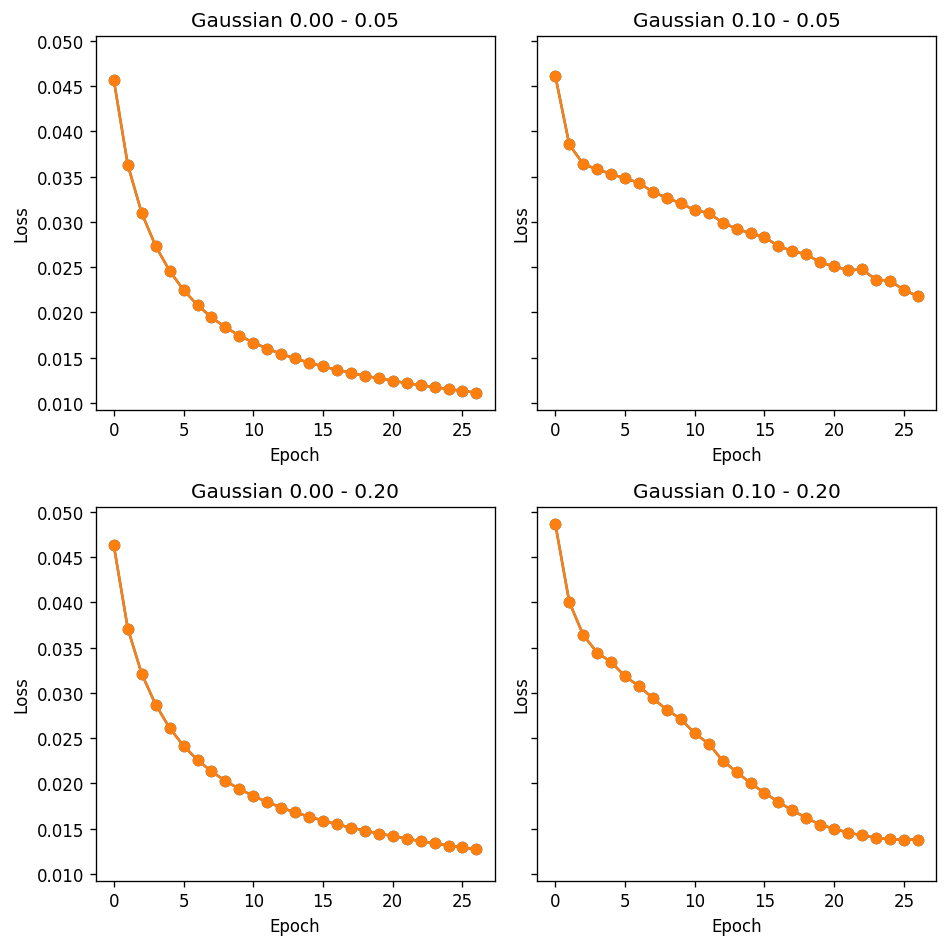

In [36]:
fig, axs = plt.subplots(2, 2, sharey='all', dpi=120, figsize=(8, 8))

for ax, losses, (p1, p2) in zip(axs.flat, __q3p1_losses, __q3p1_model_params):
    ax.set_title("Gaussian %.2f - %.2f" % (p1, p2))
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.plot(losses[0], "-o")
    ax.plot(losses[1], "-o")

fig.tight_layout()

## Question 3 Part 2
Choose one of the denoising autencoders from the previous step. Use the hidden representation to train a model to predict the number present in the image.

Plot the training and testing accuracy for each epoch during training.

In [33]:
model = __q3p1_models[1]
__q3p2_x_train = model.encode(x_train)
__q3p2_x_test  = model.encode(x_test)

__q3p2_x_train.shape, __q3p2_x_test.shape

(TensorShape([Dimension(60000), Dimension(64)]),
 TensorShape([Dimension(10000), Dimension(64)]))

In [34]:
q3p2_model = OneHiddenLayerFcModel(64, 32, 10, output_activation=tf.nn.softmax)

learning_rate = 30
num_epoch = 27
batch_size = 128

q3p2_losses = train_nn(q3p2_model, SGDStep, MeanSquareLoss, prob_accuracy,
                                __q3p2_x_train, tf.one_hot(y_train, 10), __q3p2_x_test, tf.one_hot(y_test, 10),
                                num_epochs=num_epoch,
                                batch_size=batch_size,
                                learning_rate=learning_rate)

Test loss: 0.020418
Test accuracy: 0.860500


Test loss: 0.015534
Test accuracy: 0.896400


Test loss: 0.014607
Test accuracy: 0.900100


Test loss: 0.014064
Test accuracy: 0.905600


Test loss: 0.012929
Test accuracy: 0.915300


Test loss: 0.011953
Test accuracy: 0.919800


Test loss: 0.011434
Test accuracy: 0.925200


Test loss: 0.010220
Test accuracy: 0.932400


Test loss: 0.010287
Test accuracy: 0.930200


Test loss: 0.011357
Test accuracy: 0.925500


Test loss: 0.009093
Test accuracy: 0.940500


Test loss: 0.009081
Test accuracy: 0.940000


Test loss: 0.009155
Test accuracy: 0.939200


Test loss: 0.008393
Test accuracy: 0.943700


Test loss: 0.008077
Test accuracy: 0.947000


Test loss: 0.008524
Test accuracy: 0.943600


Test loss: 0.008497
Test accuracy: 0.944100


Test loss: 0.007889
Test accuracy: 0.950600


Test loss: 0.007920
Test accuracy: 0.948100


Test loss: 0.007639
Test accuracy: 0.951000


Test loss: 0.007607
Test accuracy: 0.950200


Test loss: 0.007668
Test accuracy: 0.949600


Test loss: 0.007879
Test accuracy: 0.948800


Test loss: 0.008525
Test accuracy: 0.943000


Test loss: 0.007976
Test accuracy: 0.948100


Test loss: 0.007537
Test accuracy: 0.949300


Test loss: 0.007150
Test accuracy: 0.953400


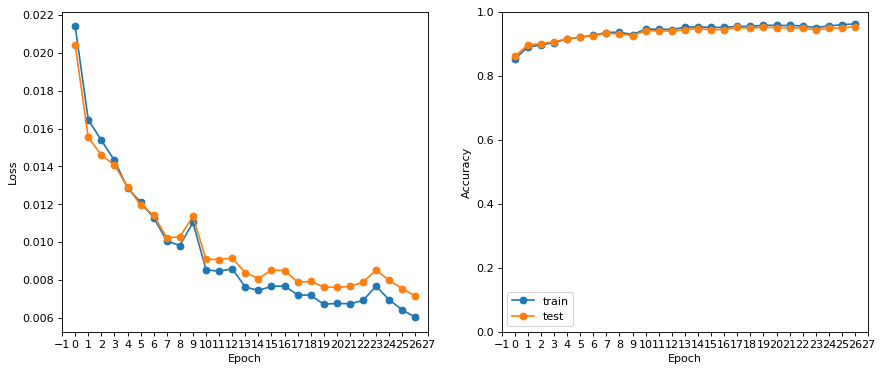

In [35]:
plot_loss_acc_by_epoch(*q3p2_losses)